### Libraries

In [1]:
import sys
import os
import time
import swifter
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(229)

/Users/vasu/AjrVasu/Coding/iit/degree/AppliedMachineLearning/envaml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ingore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Splitting

In [3]:
# read/prep data
data = pd.read_csv("../data/tokenized_reviews.csv")

In [4]:
data = data.dropna()
data["quote"] = data["quote"].astype(int)

In [5]:
print(data.shape, "\n\n")

(1710118, 14) 




In [6]:
data["tokenized_words"] = data["tokenized_words"].apply(lambda x: x.strip("[']").replace("', '"," "))

In [7]:
# 85% train / 15% test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["popular"]),
                                                    data["popular"],
                                                    test_size = 0.15,
                                                    stratify=data["popular"],
                                                    random_state = 229)

In [8]:
X_train.shape, y_train.shape

((1453600, 13), (1453600,))

### Down sampling

In [9]:
# undersample train set
majority_size = len(y_train[y_train==0])
minority_size = len(y_train[y_train==1])
majority_indices = y_train[y_train==0].index
rng = np.random.default_rng(seed=229)
drop_indices = rng.choice(majority_indices, majority_size-minority_size, replace=False)
X_train = X_train.drop(drop_indices)
y_train = y_train.drop(drop_indices)

In [10]:
X_train.shape, y_train.shape

((431298, 13), (431298,))

In [13]:
numerical_cols = [col for col in X_train.columns if col != 'tokenized_words']

### TF-IDF

In [117]:
# TF-IDF
print("\n\nLOGISTIC REGRESSION TF-IDF")

start_time = time.time()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidfvectorizer', TfidfVectorizer(), 'tokenized_words'),  # Apply TF-IDF to tokenized words
        ('standardscaler', StandardScaler(), numerical_cols)       # Scale numerical columns
    ], remainder='passthrough'
)

# full pipeline

tfidf_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        random_state=229,
        n_jobs=-1, verbose = 2
    )
)

# parameters to try
parameters = {
    'logisticregression__C': (10, 1, 0.01, 0.001)
}

# Set up GridSearchCV
gs_tfidf_pipe = GridSearchCV(
    tfidf_pipe, parameters,
    cv=ShuffleSplit(n_splits=1, test_size=0.15, random_state=229),
    n_jobs=-1,
    verbose=2)

gs_tfidf_pipe.fit(X_train, y_train)

total_time = time.time() - start_time
print(f"\nTraining completed in: {total_time:.2f} seconds\n\n")



LOGISTIC REGRESSION TF-IDF
Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
Exception ignored in: <function ResourceTracker.__del__ at 0x10651dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in

convergence after 430 epochs took 223 seconds
[CV] END ........................logisticregression__C=0.001; total time= 4.1min
Epoch 1, change: 1
Epoch 2, change: 0.20446603
Epoch 3, change: 0.080861719
Epoch 4, change: 0.042157175
Epoch 5, change: 0.02615154
Epoch 6, change: 0.01655695
Epoch 7, change: 0.014921619
Epoch 8, change: 0.014302628
Epoch 9, change: 0.013649706
Epoch 10, change: 0.013256437
Epoch 11, change: 0.012764477
Epoch 12, change: 0.012325773
Epoch 13, change: 0.011924866
Epoch 14, change: 0.011549521
Epoch 15, change: 0.011157327
Epoch 16, change: 0.010815706
Epoch 17, change: 0.010457271
Epoch 18, change: 0.010135872
Epoch 19, change: 0.0098063973
Epoch 20, change: 0.0094957372
Epoch 21, change: 0.0091984173
Epoch 22, change: 0.008907769
Epoch 23, change: 0.0086211033
Epoch 24, change: 0.0083514394
Epoch 25, change: 0.00808157
Epoch 26, change: 0.0078380829
Epoch 27, change: 0.0075853402
Epoch 28, change: 0.0073451241
Epoch 29, change: 0.007112793
Epoch 30, change: 

Exception ignored in: <function ResourceTracker.__del__ at 0x11031dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Epoch 1, change: 1
Epoch 2, change: 0.20537875
Epoch 3, change: 0.082558279
Epoch 4, change: 0.04379486
Epoch 5, change: 0.02753267
Epoch 6, change: 0.017666905
Epoch 7, change: 0.016050817
Epoch 8, change: 0.015540758
Epoch 9, change: 0.01498632
Epoch 10, change: 0.014692109
Epoch 11, change: 0.014291331
Epoch 12, change: 0.013944567
Epoch 13, change: 0.013625935
Epoch 14, change: 0.013332978
Epoch 15, change: 0.013013501
Epoch 16, change: 0.012745117
Epoch 17, change: 0.012450269
Epoch 18, change: 0.01219238
Epoch 19, change: 0.01191839
Epoch 20, change: 0.011660156
Epoch 21, change: 0.011412341
Epoch 22, change: 0.011166336
Epoch 23, change: 0.010919258
Epoch 24, change: 0.010687343
Epoch 25, change: 0.010449543
Epoch 26, change: 0.010239922
Epoch 27, change: 0.010012757
Epoch 28, change: 0.0097963697
Epoch 29, change: 0.0095853311
Epoch 30, change: 0.0093834574
Epoch 31, change: 0.009181581
Epoch 32, change: 0.0089826986
Epoch 33, change: 0.0087859572
Epoch 34, change: 0.0085943447

Exception ignored in: <function ResourceTracker.__del__ at 0x10514dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


 1987, change: 0.00029524314
Epoch 1988, change: 0.00029502863
Epoch 1989, change: 0.0002948191
Epoch 1990, change: 0.00029461233
Epoch 1991, change: 0.00029440472
Epoch 1992, change: 0.00029420625
Epoch 1993, change: 0.00029397931
Epoch 1994, change: 0.00029378002
Epoch 1995, change: 0.00029357155
Epoch 1996, change: 0.00029336368
Epoch 1997, change: 0.00029317632
Epoch 1998, change: 0.00029295077
Epoch 1999, change: 0.00029273864
Epoch 2000, change: 0.00029253652
Epoch 2001, change: 0.0002923425
Epoch 2002, change: 0.00029214634
Epoch 2003, change: 0.00029193249
Epoch 2004, change: 0.00029171813
Epoch 2005, change: 0.00029152001
Epoch 2006, change: 0.00029131291
Epoch 2007, change: 0.00029110588
Epoch 2008, change: 0.00029091472
Epoch 2009, change: 0.00029069174
Epoch 2010, change: 0.0002904891
Epoch 2011, change: 0.00029029359
Epoch 2012, change: 0.00029008904
Epoch 2013, change: 0.00028988399
Epoch 2014, change: 0.000289679
Epoch 2015, change: 0.00028947293
Epoch 2016, change: 0.00

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 4134 epochs took 1988 seconds
[CV] END ............................logisticregression__C=1; total time=33.5min
nge: 0.00010422823
Epoch 3923, change: 0.00010420624
Epoch 3924, change: 0.00010418556
Epoch 3925, change: 0.00010416533
Epoch 3926, change: 0.00010414442
Epoch 3927, change: 0.00010412269
Epoch 3928, change: 0.00010410118
Epoch 3929, change: 0.00010408129
Epoch 3930, change: 0.00010406019
Epoch 3931, change: 0.00010403944
Epoch 3932, change: 0.00010401887
Epoch 3933, change: 0.00010399672
Epoch 3934, change: 0.00010397666
Epoch 3935, change: 0.00010395566
Epoch 3936, change: 0.00010393609
Epoch 3937, change: 0.00010391472
Epoch 3938, change: 0.00010389456
Epoch 3939, change: 0.00010387329
Epoch 3940, change: 0.00010385213
Epoch 3941, change: 0.00010383046
Epoch 3942, change: 0.00010381116
Epoch 3943, change: 0.00010378983
Epoch 3944, change: 0.00010376904
Epoch 3945, change: 0.00010374828
Epoch 3946, change: 0.00010372899
Epoch 3947, change: 0.0001037083
Epo

Exception ignored in: <function ResourceTracker.__del__ at 0x1053c5d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


convergence after 4272 epochs took 2034 seconds
[CV] END ...........................logisticregression__C=10; total time=34.2min
1, change: 0.00010673875
Epoch 3922, change: 0.0001067197
Epoch 3923, change: 0.00010669791
Epoch 3924, change: 0.00010667746
Epoch 3925, change: 0.00010665746
Epoch 3926, change: 0.00010663677
Epoch 3927, change: 0.00010661524
Epoch 3928, change: 0.00010659393
Epoch 3929, change: 0.00010657428
Epoch 3930, change: 0.0001065534
Epoch 3931, change: 0.00010653287
Epoch 3932, change: 0.00010651252
Epoch 3933, change: 0.00010649056
Epoch 3934, change: 0.00010647074
Epoch 3935, change: 0.00010644995
Epoch 3936, change: 0.00010643062
Epoch 3937, change: 0.00010640946
Epoch 3938, change: 0.00010638954
Epoch 3939, change: 0.00010636847
Epoch 3940, change: 0.00010634752
Epoch 3941, change: 0.00010632605
Epoch 3942, change: 0.00010630699
Epoch 3943, change: 0.00010628587
Epoch 3944, change: 0.0001062653
Epoch 3945, change: 0.00010624476
Epoch 3946, change: 0.00010622572

Exception ignored in: <function ResourceTracker.__del__ at 0x1034ddd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


.00010158761
Epoch 3922, change: 0.00010156953
Epoch 3923, change: 0.00010154747
Epoch 3924, change: 0.0001015288
Epoch 3925, change: 0.00010150891
Epoch 3926, change: 0.00010148918
Epoch 3927, change: 0.00010146809
Epoch 3928, change: 0.00010144786
Epoch 3929, change: 0.00010142753
Epoch 3930, change: 0.00010140899
Epoch 3931, change: 0.0001013891
Epoch 3932, change: 0.00010136841
Epoch 3933, change: 0.00010134882
Epoch 3934, change: 0.00010133047
Epoch 3935, change: 0.00010131001
Epoch 3936, change: 0.00010128926
Epoch 3937, change: 0.00010126987
Epoch 3938, change: 0.00010125036
Epoch 3939, change: 0.00010122992
Epoch 3940, change: 0.00010121016
Epoch 3941, change: 0.00010119077
Epoch 3942, change: 0.00010117032
Epoch 3943, change: 0.0001011506
Epoch 3944, change: 0.00010113239
Epoch 3945, change: 0.00010111166
Epoch 3946, change: 0.00010109225
Epoch 3947, change: 0.00010107062
Epoch 3948, change: 0.0001010522
Epoch 3949, change: 0.00010103249
Epoch 3950, change: 0.00010101282
Epoch

In [118]:
print(gs_tfidf_pipe.cv_results_)
print(gs_tfidf_pipe.best_params_)

# save the best model with pickle
with open("./logistic_tfidf_model_cde.pkl", "wb") as f:
    pickle.dump(gs_tfidf_pipe.best_estimator_, f)

print("\nBest model saved as 'logistic_tfidf_model_cde.pkl'")

{'mean_fit_time': array([2050.51632786, 2005.35799408,  824.11742616,  240.96295905]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([3.42352533, 3.49487591, 3.84833908, 3.88131118]), 'std_score_time': array([0., 0., 0., 0.]), 'param_logisticregression__C': masked_array(data=[10.0, 1.0, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value=1e+20), 'params': [{'logisticregression__C': 10}, {'logisticregression__C': 1}, {'logisticregression__C': 0.01}, {'logisticregression__C': 0.001}], 'split0_test_score': array([0.70271273, 0.70212536, 0.69224824, 0.68088724]), 'mean_test_score': array([0.70271273, 0.70212536, 0.69224824, 0.68088724]), 'std_test_score': array([0., 0., 0., 0.]), 'rank_test_score': array([1, 2, 3, 4], dtype=int32)}
{'logisticregression__C': 10}

Best model saved as 'logistic_tfidf_model_cde.pkl'


In [119]:
# feature importance
coefficients = gs_tfidf_pipe.best_estimator_.named_steps['logisticregression'].coef_[0]
num_nonzero_coefs = len(np.where(abs(coefficients) > 0)[0])
sorted_ind = np.argsort(abs(coefficients))[::-1][:num_nonzero_coefs]
print(len(sorted_ind))

223068


In [120]:
# predict
predictions = gs_tfidf_pipe.predict(X_test)
predictions = list(map(round,predictions))

In [121]:
# evaluate
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Specificity :", tn/(fp+tn))
print("ROC-AUC :", roc_auc_score(y_test, predictions))

[[164385  54077]
 [ 13121  24935]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83    218462
           1       0.32      0.66      0.43     38056

    accuracy                           0.74    256518
   macro avg       0.62      0.70      0.63    256518
weighted avg       0.84      0.74      0.77    256518

Specificity : 0.7524649595810713
ROC-AUC : 0.7038417923825053


### Continous Bag Of Words

In [93]:
# BAG OF WORDS
print("\n\nLOGISTIC REGRESSION BOW")

start_time = time.time()

# column transorfmer
preprocessor = ColumnTransformer(
    transformers=[
        ('countvectorizer', CountVectorizer(), 'tokenized_words'),  
        ('standardscaler', StandardScaler(), numerical_cols)       # Scale numerical columns
    ], remainder='passthrough'
)

# full pipeline

bow_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        random_state=229,
        n_jobs=-1
    )
)

# parameters to try
parameters = {
    'logisticregression__C': (10, 1, 0.01, 0.001)
}


# Set up GridSearchCV
gs_bow_pipe = GridSearchCV(
    bow_pipe, parameters,
    cv=ShuffleSplit(n_splits=1, test_size=0.15, random_state=229),
    n_jobs=-1)

gs_bow_pipe.fit(X_train, y_train)


total_time = time.time() - start_time
print(f"\nTraining completed in: {total_time:.2f} seconds\n\n")



LOGISTIC REGRESSION BOW


Exception ignored in: <function ResourceTracker.__del__ at 0x104119d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1032d9d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/


Training completed in: 1933.92 seconds




In [94]:
print(gs_bow_pipe.cv_results_)
print(gs_bow_pipe.best_params_)

# save the best model with pickle
with open("./logistic_bow_model_cde.pkl", "wb") as f:
    pickle.dump(gs_bow_pipe.best_estimator_, f)

print("\nBest model saved as 'logistic_bow_model_cde.pkl'")

{'mean_fit_time': array([1336.34391093, 1322.17509103,  548.97386026,  108.35882878]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([2.38301492, 2.44930792, 2.70322084, 2.77604294]), 'std_score_time': array([0., 0., 0., 0.]), 'param_logisticregression__C': masked_array(data=[10.0, 1.0, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value=1e+20), 'params': [{'logisticregression__C': 10}, {'logisticregression__C': 1}, {'logisticregression__C': 0.01}, {'logisticregression__C': 0.001}], 'split0_test_score': array([0.7028673 , 0.70305279, 0.70476853, 0.70153799]), 'mean_test_score': array([0.7028673 , 0.70305279, 0.70476853, 0.70153799]), 'std_test_score': array([0., 0., 0., 0.]), 'rank_test_score': array([3, 2, 1, 4], dtype=int32)}
{'logisticregression__C': 0.01}

Best model saved as 'logistic_bow_model_cdef.pkl'


In [95]:
# feature importance
coefficients = gs_bow_pipe.best_estimator_.named_steps['logisticregression'].coef_[0]
num_nonzero_coefs = len(np.where(abs(coefficients) > 0)[0])
sorted_ind = np.argsort(abs(coefficients))[::-1][:num_nonzero_coefs]
print(len(sorted_ind))

223068


In [96]:
# Access the CountVectorizer from the ColumnTransformer
feature_names = gs_bow_pipe.best_estimator_.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names_out()
sorted_ind_filtered = sorted_ind[sorted_ind < len(feature_names)]
important_features = np.take(feature_names, sorted_ind_filtered.tolist())
print('important-features:', important_features[:10])

important-features: ['br' 'buddy' 'instagram' 'gr' 'kindly' 'update' 'supplied' 'generously'
 'maas' 'eff']


In [110]:
# predict
predictions = gs_bow_pipe.predict(X_test)
predictions = list(map(round,predictions))

In [111]:
# evaluate
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Specificity :", tn/(fp+tn))
print("ROC-AUC :", roc_auc_score(y_test, predictions))

[[172958  45504]
 [ 14293  23763]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85    218462
           1       0.34      0.62      0.44     38056

    accuracy                           0.77    256518
   macro avg       0.63      0.71      0.65    256518
weighted avg       0.84      0.77      0.79    256518

Specificity : 0.7917074823081359
ROC-AUC : 0.7080646934349173


### Word2vec

#### Dependencies change for word2vec

In [40]:
# Install compatible versions for gensim
# numpy==1.26.4

print(f"NumPy: {numpy.__version__}\nGensim: {gensim.__version__}")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
NumPy: 1.26.4
Gensim: 4.3.3


In [11]:
print("\n\nLOGISTIC REGRESSION WORD2VEC")

# Custom transformer for Word2Vec averaging
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=1, seed=229):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.seed = seed
        self.model = None

    def fit(self, X, y=None):
        # Handle different input types
        if isinstance(X, np.ndarray):
            sentences = [doc.split() for doc in X.ravel()]
        elif isinstance(X, pd.DataFrame):
            sentences = [doc.split() for doc in X.iloc[:, 0]]
        else:
            sentences = [doc.split() for doc in X]

        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window,
                              min_count=self.min_count, workers=self.workers, seed=self.seed)
        return self

    def transform(self, X):
        # Handle different input types
        if isinstance(X, np.ndarray):
            documents = pd.Series(X.ravel())
        elif isinstance(X, pd.DataFrame):
            documents = X.iloc[:, 0]
        else:
            documents = X

        def document_vector(doc):
            words = [word for word in doc.split() if word in self.model.wv]
            if not words:
                return np.zeros(self.vector_size)
            return np.mean(self.model.wv[words], axis=0)

        # Parallelize with swifter
        return np.vstack(documents.apply(document_vector))



LOGISTIC REGRESSION WORD2VEC


In [14]:
# Pipeline for Word2Vec + Logistic Regression
start_time = time.time()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('word2vec', Word2VecVectorizer(vector_size=100, window=5, min_count=2, workers=4, seed=229),'tokenized_words'),  # Apply Word2Vec to tokenized words
        ('standardscaler', StandardScaler(), numerical_cols)       # Scale numerical columns
    ], remainder='passthrough'
)

# full pipeline

w2v_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        random_state=229,
        n_jobs=-1
    )
)

# Define parameter grid
parameters = {'logisticregression__C': (10, 1, 0.01, 0.001)}

# Set up GridSearchCV
gs_w2v_pipe = GridSearchCV(
    w2v_pipe,
    parameters,
    cv=ShuffleSplit(n_splits=1, test_size=0.15, random_state=229),
    n_jobs=-1,
)

# Fit the model
gs_w2v_pipe.fit(X_train, y_train)

total_time = time.time() - start_time
print(f"\nTraining completed in: {total_time:.2f} seconds\n\n")

Exception ignored in: <function ResourceTracker.__del__ at 0x10bbc9d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10771dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/


Training completed in: 1345.13 seconds




Exception ignored in: <function ResourceTracker.__del__ at 0x10791dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106be5d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

In [15]:
print(gs_w2v_pipe.cv_results_)
print(gs_w2v_pipe.best_params_)

{'mean_fit_time': array([1049.15076494, 1082.65946388,  568.93351388,  291.48204017]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([7.07168078, 6.91714597, 7.44075418, 7.84821773]), 'std_score_time': array([0., 0., 0., 0.]), 'param_logisticregression__C': masked_array(data=[10.0, 1.0, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value=1e+20), 'params': [{'logisticregression__C': 10}, {'logisticregression__C': 1}, {'logisticregression__C': 0.01}, {'logisticregression__C': 0.001}], 'split0_test_score': array([0.68928047, 0.68989876, 0.68992967, 0.69022336]), 'mean_test_score': array([0.68928047, 0.68989876, 0.68992967, 0.69022336]), 'std_test_score': array([0., 0., 0., 0.]), 'rank_test_score': array([4, 3, 2, 1], dtype=int32)}
{'logisticregression__C': 0.001}


In [16]:
# save the best model with pickle
with open("./logistic_w2v_model_cde.pkl", "wb") as f:
    pickle.dump(gs_w2v_pipe.best_estimator_, f)

print("\nBest model saved as 'logistic_w2v_model_cde.pkl'")


Best model saved as 'logistic_w2v_model_cde.pkl'


In [17]:
# Feature importance for word2vec (vector coefficients)
coefficients = gs_w2v_pipe.best_estimator_.named_steps['logisticregression'].coef_[0]
num_nonzero_coefs = len(np.where(abs(coefficients) > 0)[0])
sorted_ind = np.argsort(abs(coefficients))[::-1][:num_nonzero_coefs]
# print(len(sorted_ind))
# print(np.take(coefficients,sorted_ind.tolist()))
print(f"Number of features (word2vec vector size): {len(coefficients)}")

Number of features (word2vec vector size): 112


In [18]:
# the top 10 features
top_10_indices = np.argsort(np.abs(coefficients))[-10:]  # Indices of top 10 features
print("Top 10 feature indices:", top_10_indices)
print("Top 10 coefficients:", coefficients[top_10_indices])

Top 10 feature indices: [ 99  69  50  84  15  94 104 103 102 100]
Top 10 coefficients: [ 0.16023542 -0.17737856 -0.18295665 -0.1892604   0.19508115  0.21672249
  0.35959365  0.43758462 -0.49366282  0.72624105]


In [19]:
#predictions
predictions = gs_w2v_pipe.predict(X_test)
predictions = list(map(round,predictions))

In [20]:
# evaluate
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Specificity :", tn/(fp+tn))
print("ROC-AUC :", roc_auc_score(y_test, predictions))

[[161547  56915]
 [ 13867  24189]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82    218462
           1       0.30      0.64      0.41     38056

    accuracy                           0.72    256518
   macro avg       0.61      0.69      0.61    256518
weighted avg       0.83      0.72      0.76    256518

Specificity : 0.7394741419560381
ROC-AUC : 0.6875450381842414


### Adjusting Threshold values to improve model performance

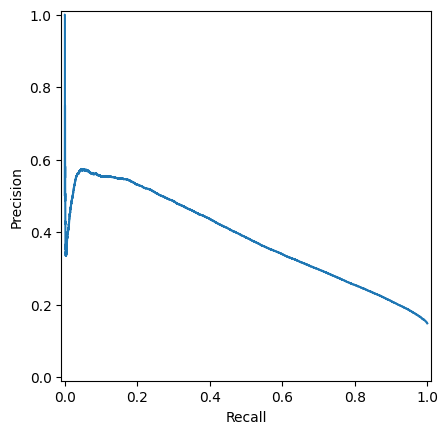

In [114]:
y_test_pred_prob = gs_w2v_pipe.predict_proba(X_test)  # gs_w2v_pipe is your best trained model
test_probs = y_test_pred_prob[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, test_probs)

#Plot Precision-Recall Curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

In [115]:
# Find optimal threshold that maximizes F1 score
f1_scores = 2 * recall * precision / (recall + precision)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f'\nThe Optimal threshold value is {optimal_threshold:.3f}')

# Predict with new optimal threshold
y_test_th_pred = (test_probs >= optimal_threshold).astype(int)


The Optimal threshold value is 0.577


In [116]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_test_th_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_th_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_test_th_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88    218462
           1       0.37      0.53      0.44     38056

    accuracy                           0.80    256518
   macro avg       0.64      0.69      0.66    256518
weighted avg       0.83      0.80      0.81    256518


Confusion Matrix:
[[184024  34438]
 [ 17824  20232]]

ROC AUC Score:
0.6869995936794107


### All Sample, No down sampling
#### Logistic Regression with BoW

In [122]:
# read/prep data
data = pd.read_csv("../data/tokenized_reviews.csv")
data = data.dropna()
data["quote"] = data["quote"].astype(int)
data["tokenized_words"] = data["tokenized_words"].apply(lambda x: x.strip("[']").replace("', '"," "))

# 85% train / 15% test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["popular"]),
                                                    data["popular"],
                                                    test_size = 0.15,
                                                    stratify=data["popular"],
                                                    random_state = 229)
X_train.shape, y_train.shape

((1453600, 13), (1453600,))

In [123]:

# BAG OF WORDS
print("\n\nLOGISTIC REGRESSION BOW, FULL SAMPLE")

start_time = time.time()

# column transofrmer
preprocessor = ColumnTransformer(
    transformers=[
        ('countvectorizer', CountVectorizer(), 'tokenized_words'),  
        ('standardscaler', StandardScaler(), numerical_cols)       # Scale numerical columns
    ], remainder='passthrough'
)

# full pipeline
bow_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        random_state=229,
        n_jobs=-1
    )
)

# parameters to try
parameters = {
    'logisticregression__C': (10, 1, 0.01, 0.001)
}

# Set up GridSearchCV
gs_bow_pipe = GridSearchCV(
    bow_pipe, parameters,
    cv=ShuffleSplit(n_splits=1, test_size=0.15, random_state=229),
    n_jobs=-1)

gs_bow_pipe.fit(X_train, y_train)

total_time = time.time() - start_time
print(f"\nTraining completed in: {total_time:.2f} seconds\n\n")



LOGISTIC REGRESSION BOW, FULL SAMPLE


Exception ignored in: <function ResourceTracker.__del__ at 0x10783dd00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1035a5d00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/


Training completed in: 7836.16 seconds




In [124]:
print(gs_bow_pipe.cv_results_)
print(gs_bow_pipe.best_params_)

# save the best model with pickle
with open("./logistic_bow_model_f.pkl", "wb") as f:
    pickle.dump(gs_bow_pipe.best_estimator_, f)

print("\nBest model saved as 'logistic_bow_model_f.pkl'")

{'mean_fit_time': array([4344.46122384, 4319.23325396, 1630.73264313, 6364.86954284]), 'std_fit_time': array([0., 0., 0., 0.]), 'mean_score_time': array([7.28224611, 7.44915199, 8.14059806, 6.82989907]), 'std_score_time': array([0., 0., 0., 0.]), 'param_logisticregression__C': masked_array(data=[10.0, 1.0, 0.01, 0.001],
             mask=[False, False, False, False],
       fill_value=1e+20), 'params': [{'logisticregression__C': 10}, {'logisticregression__C': 1}, {'logisticregression__C': 0.01}, {'logisticregression__C': 0.001}], 'split0_test_score': array([0.86134654, 0.86137865, 0.86141992, 0.86003944]), 'mean_test_score': array([0.86134654, 0.86137865, 0.86141992, 0.86003944]), 'std_test_score': array([0., 0., 0., 0.]), 'rank_test_score': array([3, 2, 1, 4], dtype=int32)}
{'logisticregression__C': 0.01}

Best model saved as 'logistic_bow_model_f.pkl'


In [125]:
# predict
predictions = gs_bow_pipe.predict(X_test)
predictions = list(map(round,predictions))

In [126]:
# evaluate
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Specificity :", tn/(fp+tn))
print("ROC-AUC :", roc_auc_score(y_test, predictions))

[[213904   4558]
 [ 31204   6852]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92    218462
           1       0.60      0.18      0.28     38056

    accuracy                           0.86    256518
   macro avg       0.74      0.58      0.60    256518
weighted avg       0.83      0.86      0.83    256518

Specificity : 0.9791359595719163
ROC-AUC : 0.5795932057687204
